## 1. Постановка задачи

Дан направленный граф социальной сети. Каждая вершина графа соответствует одному пользователю социальной сети. 
Каждое направленное ребро графа, от вершины u к вершине v соответствует присутствию пользователя v в списке друзей пользователя u.
Каждое ребро имеет атрибуты: time - сколько времени прошло с тех пор как пользователь u добавил в друзья пользователя v,
intensity - насколько активно пользователи взаимодействуют в сети.

Необходимо предсказать появление новых ребер в графе, отсортировав их по вероятности появления. 
Для одной вершины графа нужно найти 5 новых наиболее вероятных ребер.

Качество рекомендаций будем оценивать с помощью метрики Precision@5, которую будем стремиться максимизировать.

#### Примечания

1) При постановке и решении задачи я исхожу из предположения, что для исследования был предоставлен полный подграф социальной сети для тех пользователей, которые в нем присутствуют.

2) Поскольку не для всех ребер исходного графа существует противоположно направленное ребро, соединяющее те же вершины, будем считать, что пользователь u дружит с пользователем v, если в графе присутствует ребро, направленное от u к v. При этом ребро от v к u может отсутствовать, и тогда будем говорить, что пользователь v не дружит с пользователем u. То есть, в контексте данной задачи понятие дружбы несимметричное.

In [125]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from operator import itemgetter, attrgetter
import random
import pickle

import importlib
import sn_graph_functions as gf
importlib.reload(gf)
import predictor as pred
importlib.reload(pred)

<module 'predictor' from 'G:\\Develop\\Repositories\\VK_test\\version3\\predictor.py'>

## 2. Загрузка данных

In [126]:
data = pd.read_csv('data/friends_dataset', sep=',', header = None, names=['id1','id2','time','intensity'])

In [127]:
initial_graph = gf.create_initial_graph("data/friends_dataset")

In [128]:
data.head()

,id1,id2,time,intensity
0,4052919,1559975,264.475747,0.000000
1,9245023,7458626,265.061965,0.000505
2,7067801,11205937,264.449128,0.000067
3,3727103,6167658,259.803427,0.035294
4,14887121,10181839,263.830863,0.181074


In [129]:
data.nunique()

id1           37342
id2           43582
time         495535
intensity    981443
dtype: int64

In [130]:
data['mutual'] = data[['id1','id2']].apply(lambda row: gf.edge_is_mutual(a=row[0], b=row[1], g=initial_graph), axis=1)

In [131]:
data['mutual'].value_counts()

1    978530
0     57294
Name: mutual, dtype: int64

Большая часть связей двусторонняя, однако есть связи в одну сторону

## 3. Посмотрим на данные

#### Посмотрим на небольшой подграф

User id=5111813 with friends of friends subgraph


c:\users\jul\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\users\jul\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


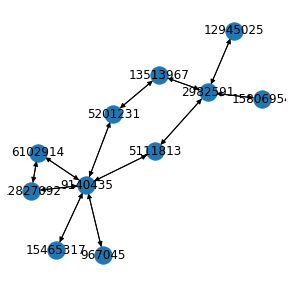

In [132]:
sample_user = list(initial_graph.nodes())[1]
sample_nodes = set(gf.friends_of_friends(sample_user , initial_graph)).union(set(initial_graph.neighbors(sample_user))).union(set([sample_user]))
subg = nx.subgraph(initial_graph, sample_nodes)
print("User id={} with friends of friends subgraph".format(sample_user))
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
nx.draw(subg, with_labels=True)

### Количество подписчиков

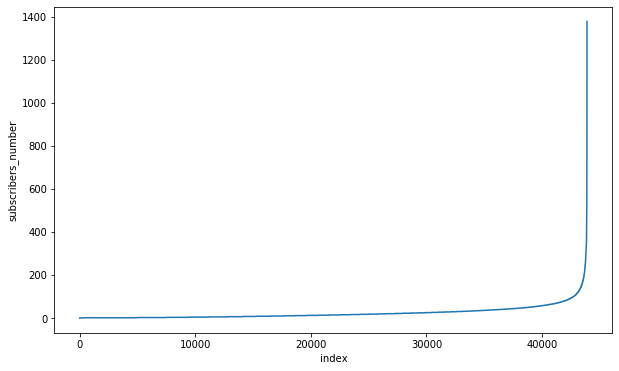

In [133]:
subscribers_number = list(dict(initial_graph.in_degree()).values())
subscribers_number.sort()
plt.figure(figsize=(10,6))
plt.plot(subscribers_number)
plt.xlabel('index')
plt.ylabel('subscribers_number')
plt.show()

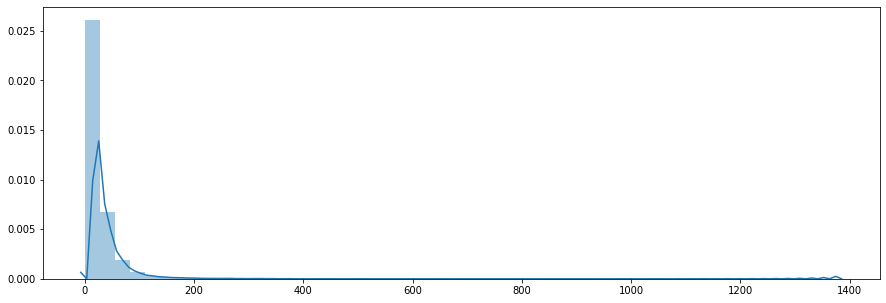

In [134]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.distplot(subscribers_number, ax=ax)

### Количество друзей (подписок)

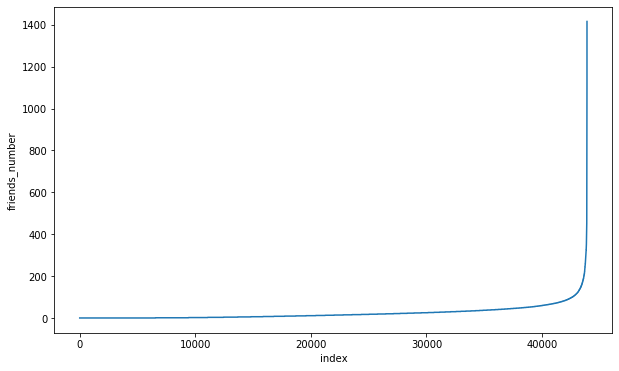

In [135]:
friends_number = list(dict(initial_graph.out_degree()).values())
friends_number.sort()
plt.figure(figsize=(10,6))
plt.plot(friends_number)
plt.xlabel('index')
plt.ylabel('friends_number')
plt.show()

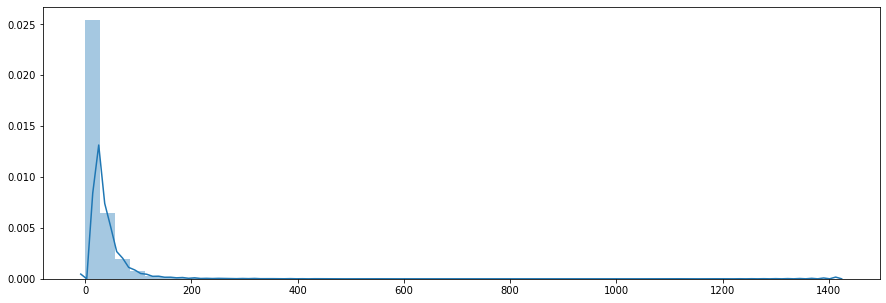

In [136]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.distplot(friends_number, ax=ax)

In [137]:
print("Number of users with no subscribers: {}".format(np.sum(np.array(subscribers_number)==0)))

Number of users with no subscribers: 313


In [138]:
print("Number of users with no friends: {}".format(np.sum(np.array(friends_number)==0)))

Number of users with no friends: 6553


In [139]:
no_subscribers_users = set([k for k, v in dict(initial_graph.in_degree()).items() if v == 0])
no_friends_users = set([k for k, v in dict(initial_graph.out_degree()).items() if v == 0])
no_links_users = no_subscribers_users.intersection(no_friends_users)

print("Number of users with no links (no friends and subscribers): {}".format(len(no_links_users)))

Number of users with no links (no friends and subscribers): 0


### Время, прошедшее с момента подписки

In [140]:
data['time'].describe()

count    1.035824e+06
mean     2.634340e+02
std      8.138869e+00
min      2.486533e+02
25%      2.576985e+02
50%      2.617655e+02
75%      2.649766e+02
max      2.767799e+02
Name: time, dtype: float64

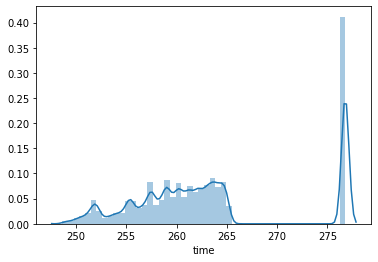

In [141]:
sns.distplot(data['time'])

Всплеск активности по добавлению друзей в небольшой промежуток времени с последующим спадом выглядит довольно подозрительно.
Посмотрим, как соотносятся между собой списки пользователей, которые добавляли друзей в этот промежуток времени и позднее.
Если эти списки сильно отличаются, это могло бы означать, например, что в определенный момент была вспышка активности спамеров, а потом с этим начали как-то бороться. 
Или это был период активного привлечения социальной сетью новых пользователей, которые сразу добавили множество своих знакомых в друзья. Или произошло еще какое-либо событие.

In [142]:
print("Количество уникальных пользователей, добавлявших друзей во время всплеска: {}".format(data[data['time']>274]['id1'].nunique()))

Количество уникальных пользователей, добавлявших друзей во время всплеска: 16410


In [143]:
print("Количество уникальных пользователей, добавлявших друзей после всплеска: {}".format(data[data['time']<=274]['id1'].nunique()))

Количество уникальных пользователей, добавлявших друзей после всплеска: 36405


In [144]:
print("Пересечение множества пользователей, добавлявших друзей во время всплеска и после: {}".format(len(set(data[data['time']>274]['id1']).intersection(set(data[data['time']<=274]['id1'])))))

Пересечение множества пользователей, добавлявших друзей во время всплеска и после: 15473


Большинство пользователей, добавлявших друзей во время всплеска, продолжили добавлять их и после. Посмотрим еще распределения количеств добавляемых друзей в разрезе пользователей, до и после пика.

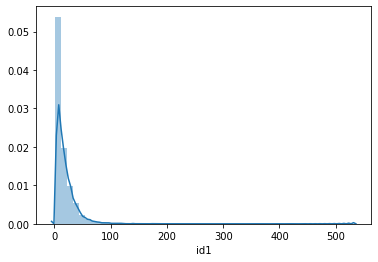

In [145]:
sns.distplot(data[data['time']>274]['id1'].value_counts())

In [146]:
pd.DataFrame(data[data['time']>274]['id1'].value_counts())['id1'].describe()

count    16410.000000
mean        14.611822
std         17.585287
min          1.000000
25%          3.000000
50%          9.000000
75%         20.000000
max        530.000000
Name: id1, dtype: float64

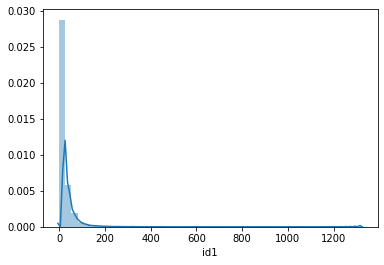

In [147]:
sns.distplot(data[data['time']<=274]['id1'].value_counts())

In [148]:
pd.DataFrame(data[data['time']<=274]['id1'].value_counts())['id1'].describe()

count    36405.000000
mean        21.866337
std         35.474341
min          1.000000
25%          4.000000
50%         11.000000
75%         27.000000
max       1319.000000
Name: id1, dtype: float64

In [149]:
pd.DataFrame(data['id1'].value_counts())['id1'].quantile(0.99)

173.0

In [150]:
super_social_users = pd.DataFrame(data['id1'].value_counts())
quant99 = super_social_users['id1'].quantile(0.99)
super_social_users = list(super_social_users[super_social_users['id1']>=quant99].index)
print(super_social_users)

[7976454, 16543998, 5605896, 7274553, 8992131, 498794, 1246712, 5201231, 4566101, 1586393, 3252350, 580606, 1291755, 5455242, 15339566, 4758381, 6555816, 6309331, 202399, 7315194, 1063675, 13416373, 9100077, 13215000, 2309004, 6482065, 9417934, 15938283, 6539113, 86527, 4210678, 10055502, 14011967, 4266715, 12572639, 1999751, 9430710, 12229278, 9309589, 923692, 15838146, 10419341, 814212, 15729265, 3434578, 166886, 15928220, 4596927, 3760117, 11629146, 2362444, 12086650, 11033733, 6004248, 13804838, 12032005, 2811451, 16182800, 1694172, 872974, 1473266, 5983046, 3969605, 3741062, 10330537, 10751312, 16333246, 4849060, 10619175, 1384866, 2799621, 12708229, 5627294, 6261712, 15862705, 6576529, 817763, 11308979, 2724873, 9932783, 1288146, 9498557, 2418192, 14534067, 15467932, 13635581, 7419472, 3061685, 2619837, 2516073, 364319, 13636111, 14253390, 3395065, 8319409, 12410627, 12189240, 5342370, 2341388, 4183413, 11246324, 9184478, 7524180, 16232656, 12748183, 6689821, 16411292, 6326944, 5

Вроде бы, совсем больших аномалий нет, но есть пользователи, которые очень активно добавляют друзей на общем фоне. 

При построении моделей можно попробовать самых активных исключить, и посмотреть, как это повлияет на качество.

### Интенсивность взаимодействия в сети

In [151]:
data['intensity'].describe()

count    1.035824e+06
mean     4.102631e-01
std      5.701604e-01
min      0.000000e+00
25%      1.981880e-03
50%      1.213718e-01
75%      6.948412e-01
max      4.876622e+00
Name: intensity, dtype: float64

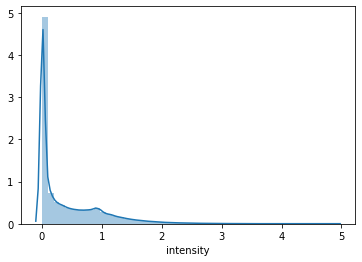

In [152]:
sns.distplot(data['intensity'])

Тут картина более-менее ожидаемая

## 4. По датасету с признаками

### Количество общих друзей у пар пользователей друзей и пар не-друзей

In [153]:
train_data = pd.DataFrame(pred.load_from_pickle("data/train_data_shuffled"), columns = ['feature_common_friends_mean_intensity','feature_common_friends_sum_intensity','feature_common_friends_mean_time','feature_common_friends_sum_time',
            'feature_common_friends_count','feature_AdamicAdar','feature_ResourceAllocation','feature_JaccardCoefficent','feature_PreferentialAttachment','has_back_link','id1','id2','friends'])

In [154]:
train_data.head().T

,0,1,2,3,4
feature_common_friends_mean_intensity,4.397035e-01,2.943940e-01,3.117316e-01,6.913080e-02,6.177037e-01
feature_common_friends_sum_intensity,1.758814e+00,1.148137e+01,5.891728e+01,1.354964e+01,7.844838e+01
feature_common_friends_mean_time,2.601726e+02,2.638777e+02,2.626916e+02,2.711991e+02,2.606263e+02
feature_common_friends_sum_time,1.040691e+03,1.029123e+04,4.964871e+04,5.315503e+04,3.309954e+04
feature_common_friends_count,1.000000e+00,5.000000e+00,1.300000e+01,1.700000e+01,1.300000e+01
feature_AdamicAdar,1.681228e-01,1.289773e+00,3.504676e+00,4.322690e+00,3.506345e+00
feature_ResourceAllocation,2.610966e-03,1.125112e-01,3.576925e-01,3.533144e-01,3.566072e-01
feature_JaccardCoefficent,8.403361e-03,6.493506e-02,2.452830e-01,1.307692e-01,1.857143e-01
feature_PreferentialAttachment,8.403361e-03,6.493506e-02,2.452830e-01,1.307692e-01,1.857143e-01
has_back_link,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [155]:
super_social_users = pd.DataFrame(data['id1'].value_counts())
quant99 = super_social_users['id1'].quantile(0.99)
super_social_users = list(super_social_users[super_social_users['id1']>=quant99].index)

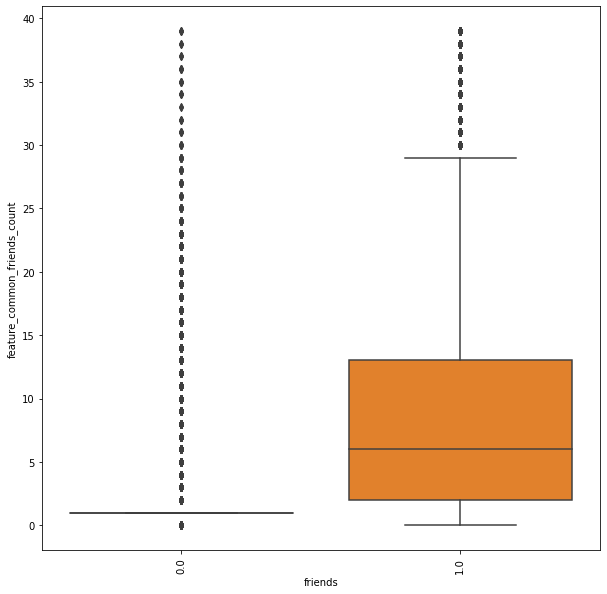

In [159]:
# Придется отсеять очень большие значения, чтобы можно было увидеть основную часть картинки
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plt.xticks(rotation='vertical')
sns.boxplot(x="friends", y="feature_common_friends_count", data=train_data[train_data['feature_common_friends_count']<40], ax=ax)

### Посмотрим на корреляции признаков, чтобы не включать в модель слишком скоррелированные

In [157]:
def draw_heatmap(data, corrtype = 'pearson'):
    corr = data.corr(method=corrtype)
    # Генерируем маску для отсечения верхней диагонали матрицы
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10, 10))
    
    sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

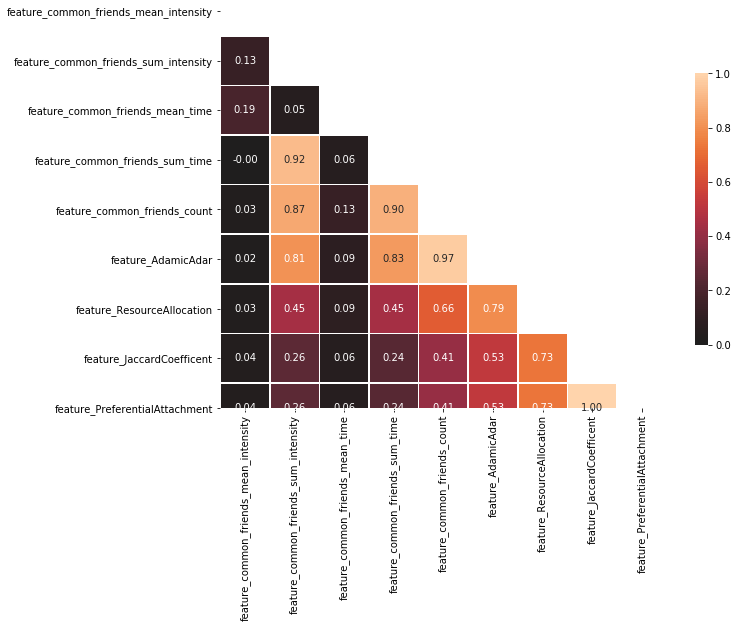

In [158]:
draw_heatmap(train_data[['feature_common_friends_mean_intensity','feature_common_friends_sum_intensity','feature_common_friends_mean_time','feature_common_friends_sum_time',
            'feature_common_friends_count','feature_AdamicAdar','feature_ResourceAllocation','feature_JaccardCoefficent','feature_PreferentialAttachment']])